### Imports

In [6]:
from sklearn.feature_selection import (
    SelectKBest,
    f_regression
)

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
data_path_train = "data/train_init.csv"
data_path_test = "data/test_init.csv"

df_train_init = pd.read_csv(data_path_train)
df_test_init = pd.read_csv(data_path_test)

print("Train shape:", df_train_init.shape)
print("Test shape:", df_test_init.shape)

Train shape: (1460, 81)
Test shape: (1459, 80)


In [3]:
num_cols = df_train_init.select_dtypes(include=['number']).shape[1]
text_cols = df_train_init.select_dtypes(include=['object', 'category']).shape[1]

print(f"Numerical columns: {num_cols}")
print(f"Text/Object columns: {text_cols}")

Numerical columns: 38
Text/Object columns: 43


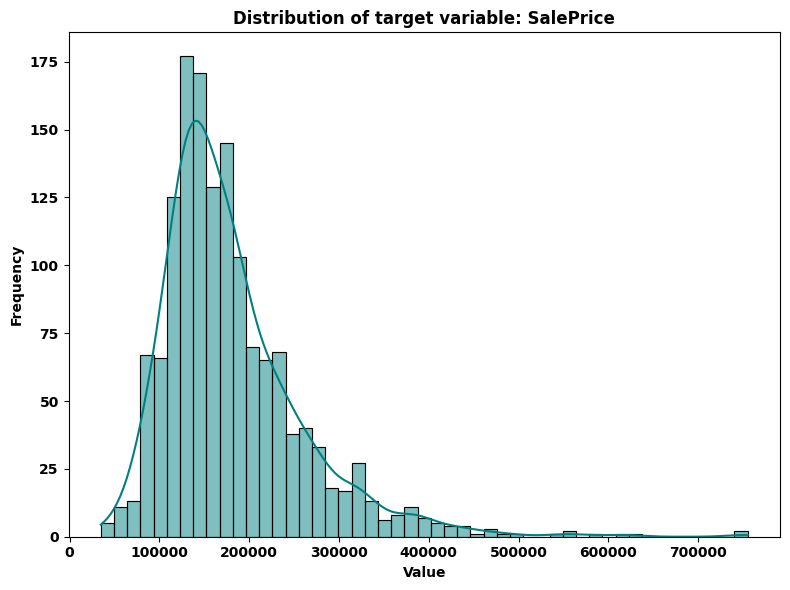

In [10]:
def plot_distribution(series):

    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.figure(figsize=(8, 6))
    sns.histplot(series, kde=True, color='teal')
    plt.title(f'Distribution of target variable: {series.name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.savefig("saleprice.png", transparent=True, dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_distribution(df_train_init['SalePrice'])

### Data inspection

In [12]:
def categorical_cardinality(df: pd.DataFrame) -> pd.DataFrame:

    cat_cols = df.select_dtypes(include=["object", "category"]).columns

    cardinality_df = (
        df[cat_cols]
        .nunique(dropna=False)
        .to_frame(name="unique_values")
        .reset_index()
        .rename(columns={"index": "feature"})
    )

    cardinality_df = cardinality_df.sort_values(
        by="unique_values",
        ascending=False
    ).reset_index(drop=True)

    return cardinality_df


In [13]:
cardinality_df = categorical_cardinality(df_train_init)

In [14]:
cardinality_df

,feature,unique_values
0,Neighborhood,25
1,Exterior2nd,16
2,Exterior1st,15
3,Condition1,9
4,SaleType,9
5,HouseStyle,8
6,RoofMatl,8
7,Condition2,8
8,BsmtFinType2,7
9,BsmtFinType1,7


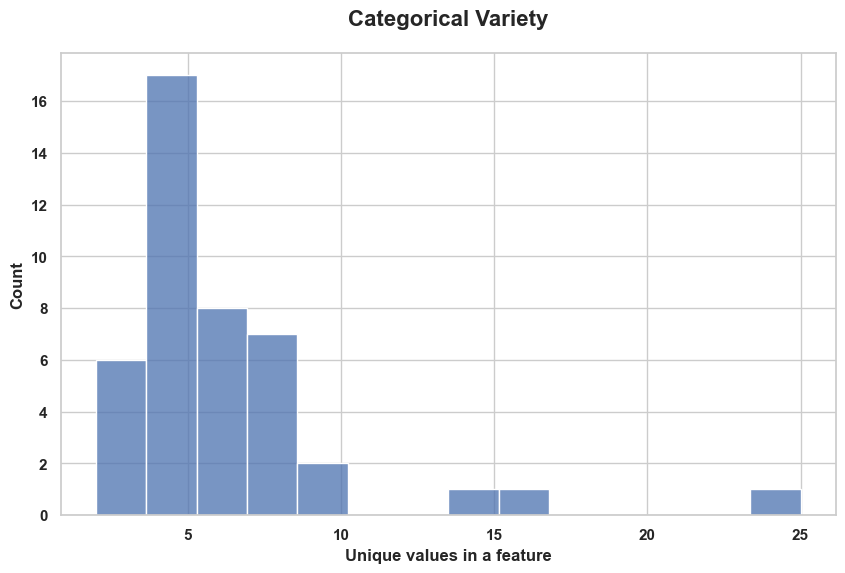

Density plot saved as unique_values.png


In [20]:
def save_density_histogram(series, filename="density_histogram.png"):

    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'

    fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')
    ax.set_facecolor('none')
    
    sns.set_theme(style="whitegrid")

    sns.histplot(
        series, 
        ax=ax, 
        edgecolor='white',
        linewidth=1
    )

    ax.set_title(f'Categorical Variety', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Unique values in a feature', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')

    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontweight('bold')

    plt.savefig(filename, transparent=True, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Density plot saved as {filename}")

save_density_histogram(cardinality_df['unique_values'], "unique_values.png")

In [21]:
def encode_train_test(df_train, df_test, target_col, ohe_threshold=5, smoothing=10):
    train_encoded = df_train.copy()
    test_encoded = df_test.copy()
    
    y_train = train_encoded[target_col]
    global_mean = y_train.mean()

    cat_cols = train_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
    if target_col in cat_cols:
        cat_cols.remove(target_col)
    
    for col in cat_cols:
        unique_vals = train_encoded[col].nunique()
        

        if unique_vals < ohe_threshold:
            print(f"OHE: {col} ({unique_vals} unique values)")
            train_dummies = pd.get_dummies(train_encoded[col], prefix=col, drop_first=True, dtype=int)
            test_dummies = pd.get_dummies(test_encoded[col], prefix=col, drop_first=True, dtype=int)
            test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)
            train_encoded = pd.concat([train_encoded.drop(columns=[col]), train_dummies], axis=1)
            test_encoded = pd.concat([test_encoded.drop(columns=[col]), test_dummies], axis=1)
            
        else:
            print(f"Target Encoding: {col} ({unique_vals} unique values)")
            kf = KFold(n_splits=5, shuffle=True, random_state=42)
            cv_series = pd.Series(index=train_encoded.index, dtype=float)
            
            for train_idx, val_idx in kf.split(train_encoded):
                X_t, X_v = train_encoded.iloc[train_idx], train_encoded.iloc[val_idx]
                y_t = y_train.iloc[train_idx]
                
                stats = X_t.assign(target=y_t).groupby(col)['target'].agg(['mean', 'count'])
                stats['te'] = ((stats['mean'] * stats['count'] + global_mean * smoothing) / 
                               (stats['count'] + smoothing))
                
                cv_series.iloc[val_idx] = X_v[col].map(stats['te']).fillna(global_mean)
            
            train_encoded[col] = cv_series
            full_stats = df_train.assign(target=y_train).groupby(col)['target'].agg(['mean', 'count'])
            
            full_stats['te'] = ((full_stats['mean'] * full_stats['count'] + global_mean * smoothing) / 
                                (full_stats['count'] + smoothing))
            
            test_encoded[col] = test_encoded[col].map(full_stats['te']).fillna(global_mean)
            
    return train_encoded, test_encoded

In [47]:
df_train, df_test = encode_train_test(df_train_init, df_test_init, 'SalePrice')

Target Encoding: MSZoning (5 unique values)
OHE: Street (2 unique values)
OHE: Alley (2 unique values)
OHE: LotShape (4 unique values)
OHE: LandContour (4 unique values)
OHE: Utilities (2 unique values)
Target Encoding: LotConfig (5 unique values)
OHE: LandSlope (3 unique values)
Target Encoding: Neighborhood (25 unique values)
Target Encoding: Condition1 (9 unique values)
Target Encoding: Condition2 (8 unique values)
Target Encoding: BldgType (5 unique values)
Target Encoding: HouseStyle (8 unique values)
Target Encoding: RoofStyle (6 unique values)
Target Encoding: RoofMatl (8 unique values)
Target Encoding: Exterior1st (15 unique values)
Target Encoding: Exterior2nd (16 unique values)
OHE: MasVnrType (3 unique values)
OHE: ExterQual (4 unique values)
Target Encoding: ExterCond (5 unique values)
Target Encoding: Foundation (6 unique values)
OHE: BsmtQual (4 unique values)
OHE: BsmtCond (4 unique values)
OHE: BsmtExposure (4 unique values)
Target Encoding: BsmtFinType1 (6 unique value

In [48]:
null_summary = (
    df_train
    .isnull()
    .sum()
    .to_frame(name="missing_count")
)
null_summary["missing_pct"] = null_summary["missing_count"] / len(df_train) * 100

null_summary = null_summary.sort_values("missing_pct", ascending=False)

display(null_summary)

,missing_count,missing_pct
LotFrontage,259,17.739726
GarageYrBlt,81,5.547945
MasVnrArea,8,0.547945
MSSubClass,0,0.000000
LotArea,0,0.000000
...,...,...
Fence_MnPrv,0,0.000000
Fence_MnWw,0,0.000000
MiscFeature_Othr,0,0.000000
MiscFeature_Shed,0,0.000000


In [38]:
def high_correlation_pairs(
    df: pd.DataFrame,
    threshold: float = 0.8,
    method: str = "pearson"
) -> pd.DataFrame:

    df_num = df.select_dtypes(include=[np.number])
    corr_matrix = df_num.corr(method=method)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    corr_pairs = (
        corr_matrix
        .where(mask)
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ["feature_1", "feature_2", "correlation"]

    corr_pairs = corr_pairs[
        corr_pairs["correlation"].abs() >= threshold
    ]

    corr_pairs = corr_pairs.sort_values(
        by="correlation",
        key=lambda x: x.abs(),
        ascending=False
    ).reset_index(drop=True)

    return corr_pairs


In [49]:
high_correlation_pairs(
    df_train
)

,feature_1,feature_2,correlation
0,SaleType,SaleCondition,0.953788
1,Exterior1st,Exterior2nd,0.938908
2,ExterQual_Gd,ExterQual_TA,-0.906121
3,GarageCars,GarageArea,0.882475
4,YearBuilt,GarageYrBlt,0.825667
5,GrLivArea,TotRmsAbvGrd,0.825489
6,KitchenQual_Gd,KitchenQual_TA,-0.824457
7,TotalBsmtSF,1stFlrSF,0.819530


In [50]:
df_train =df_train.drop(columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'SaleCondition', 'Id'], axis = 1)
df_train = df_train.fillna(0)

In [52]:
TARGET = 'SalePrice'

X = df_train.drop(columns=[TARGET], axis = 0)
y = df_train[TARGET]

X_num = X

selector_f = SelectKBest(score_func=f_regression, k='all')
selector_f.fit(X_num.fillna(X_num.median()), y)

feature_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': selector_f.scores_
}).sort_values('f_score', ascending=False)

display(feature_scores)

,feature,f_score
10,OverallQual,2436.770591
5,Neighborhood,1580.066684
33,GrLivArea,1470.585010
44,GarageArea,926.951287
26,TotalBsmtSF,880.341282
...,...,...
35,BsmtHalfBath,0.413789
90,PoolQC_Fa,0.379275
65,Utilities_NoSeWa,0.298804
91,PoolQC_Gd,0.211326


In [53]:
def get_low_correlation_features(df, target_col, threshold=0.1):

    corr_matrix = df.corr()
    target_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
    low_corr_features = target_corr[target_corr < threshold].index.tolist()
    
    return low_corr_features

threshold = 0.02
to_drop = get_low_correlation_features(df_train, 'SalePrice', threshold)

print(f"Weak correlation variables: {to_drop}")

Weak correlation variables: ['BsmtHalfBath', 'PoolQC_Fa', 'Utilities_NoSeWa', 'PoolQC_Gd', 'BsmtFinSF2']


In [54]:
df_train.to_csv('./data/df_train.csv', index = False)
df_test.to_csv('./data/df_test.csv', index = False)

In [56]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,...,PavedDrive_P,PavedDrive_Y,PoolQC_Fa,PoolQC_Gd,Fence_GdWo,Fence_MnPrv,Fence_MnWw,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC
0,60,191233.328298,65.0,8450,177369.498778,196200.387278,184468.419410,181311.718287,185924.048163,210207.534512,...,0,1,0,0,0,0,0,0,0,0
1,20,191788.168068,80.0,9600,171965.477367,197950.747432,145641.602037,181316.743092,185992.901466,176000.725015,...,0,1,0,0,0,0,0,0,0,0
2,60,191233.328298,68.0,11250,177369.498778,196200.387278,184468.419410,181311.718287,185924.048163,210207.534512,...,0,1,0,0,0,0,0,0,0,0
3,70,191083.315173,60.0,9550,181031.048924,209292.570590,183441.463446,179950.057426,184738.379056,206117.742353,...,0,1,0,0,0,0,0,0,0,0
4,60,190160.409288,84.0,14260,183133.412150,307844.650207,185224.486659,181773.307261,185825.316224,211194.491691,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,191233.328298,62.0,7917,177369.498778,189828.113699,184468.419410,181311.718287,185924.048163,210207.534512,...,0,1,0,0,0,0,0,0,0,0
1456,20,191083.315173,85.0,13175,176089.549893,188693.395843,183441.463446,179950.057426,184738.379056,175524.309052,...,0,1,0,0,0,1,0,0,0,0
1457,70,191788.168068,66.0,9042,176830.309975,205455.570590,184580.313936,181316.743092,185992.901466,210342.211845,...,0,1,0,0,0,0,0,0,1,0
1458,20,190160.409288,68.0,9717,176192.888970,148487.683384,185224.486659,181773.307261,185825.316224,176209.937325,...,0,1,0,0,0,0,0,0,0,0
